For data science training using Python, Kaggle is a great resource for open source datasets:

https://www.kaggle.com

This session will use the Bosch manufacturing plant dataset which consists of monitoring data related to a component being created on an assembly line:

https://www.kaggle.com/c/bosch-production-line-performance/data

Like many open industrial datasets, the values have been altered to obfuscate the original data but maintain the underlying trends.

In [115]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [38]:
# set relative path to data folder

data_path = "data/"

In [39]:
# let's use the os library to view the files at the specified location

filelist = os.listdir(data_path)
filelist

['test_categorical.csv',
 'train_categorical.csv',
 'train_numeric.csv',
 'test_numeric.csv',
 'test_date.csv',
 'train_date.csv']

In [51]:
# let's load a single file to check what we are dealing with (this may take some time depending on your hardware specs)

# specify a file from our previously loaded filelist
filename = filelist[2]

# set the file location to load using the relative data path set above
pathandfile = data_path+filename

# using pandas (which has been imported/abbreviated to 'pd'), load in the data. N.B. it is much quicker to load a smaller sample by specifying nrows
df = pd.read_csv(pathandfile, nrows=100000)

# print the loadef filename for clarity
print(filename)

train_numeric.csv


We now have loaded the .csv file into Python using pandas and assigned the data to variable 'df'. This name is commonly used in pandas examples online but the name can be something more descriptive, especially when loading in multiple datasets. We will address this later on in the notebook.

First things first, let's display a small amount of the loaded loaded file using the pandas 'head' function

In [52]:
# 'head' can specify the number of rows to includes (plus the column headings)

df.head(10)

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,13,0.003,0.019,0.294,0.312,0.031,0.161,0.022,0.088,-0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,18,-0.016,-0.041,-0.179,-0.179,-0.056,0.161,-0.007,-0.032,-0.082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


It looks likes the data file consists of 970 columns of data. This might be a good time to explain pandas a little more:
- Pandas is a little like an excel file in it's organisational structure.
- By default, an index will be generated on the left hand side starting at 0 until the final data row.
- There are column names that pandas will automatically pull from within the .csv (or other file).
- The data is organised into columns corresponding to the structure in the original data file.

In this case of this data set, the first column is a component identification reference number with column name 'Id'. The last column named 'Response' is a reference to the component status, with 0 passing inspection, and 1 a failure. The columns in between are sensor values from Bosch manufacturing equipment. We do not know what these values correspond to, nor if they are based on time. To speculate, these may be temperature values at different stages of the process.

For our application, we do not really care. What are are interesting in is using these values to create a model that can predict the values of 'Response' to a high degree of accuracy as that value indicates whether or not a component was successfully made. If we can determine that sensor values that correspond to a part that will fail, the factory can change their process to reduce these failures, or take corrective action to prevent the failure from developing.

First things first, we need to check our data for a few things. Let's look at the 'Response' column to see if we are indeed dealing with only 2 states - 0 and 1:

In [53]:
# the total dataset is assigned to varaiable df, but we can filter by column name to perform some functions.
# value_counts()' is useful to check the range of values and their frequency

df['Response'].value_counts()

0    99432
1      568
Name: Response, dtype: int64

We can see the column 'Response' consists of 2 values, 0 which occurs 99432 times and 1 occuring 568 times (i.e. 568 component failures). Let's test this on one of the data columns to see the result:

In [54]:
df['L0_S0_F2'].value_counts()

-0.004    1884
-0.011    1857
 0.033    1844
 0.004    1844
 0.026    1832
          ... 
-0.399       2
-0.429       1
-0.369       1
-0.392       1
-0.474       1
Name: L0_S0_F2, Length: 93, dtype: int64

As the range of values of data is far greater, we get a less meaningful response from value counts due to the larger number. Later we will look at histograms to derive this information and present it instead.

From looking at the small smaple provided by df.head(), it is clear there are lots of 'NaN' - Not a Number. This is a common programming term to indicate a value that is not numerical within a set of numerical values. These are commonly found in data science applications and may indicate where a sensor did not provide a value correctly or where there was some anomoly. Dealing with them can be tricky there and is specific to the application:
- Do we remove the entire row even if there is only one NaN among them? This is safe but can lead to lots of good data being dropped.
- Do we replace with zero's? If zero has some meaning, then this should not be done.
- Do we assign some numerical value outwith the range of the expected data values, like a negative or a complex number, so we can keep the rows and carry out analysis whilst keeping the 'NaN' values identifiable?
- DO we just leave them and adapt our analaysis to ignore the NaN's? This may result in skewed results where a component may have lots of NaNs and so will be influenced by data outliers.

Generally, dropping rows that contain NaN values is best, so long as the total dataset is not significantly reduced. Let's test dropping rows (i.e. components) that have sensor values with NaN in them:

In [56]:
# let's create a new subset of the data contained in 'df' called 'df_filt'
# where any row that containes 1 or more NaNs is removed

df_filt = df.dropna(how='any')
df_filt.head(10)

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response


Oh dear, we have removed all the data by being overzealous in our quest for pure data! In this application, some of the sensors appear to always produce NaN values (likely inactive) and so removing any component that has a NaN value in the row is not a viable approach. As the values from the sensor range from negative to postive around zero, assigning them a value, we cannot really assign a replacement value. The only approach we can take is to leave the NaN values in for now and adapt any future analysis to accommodate for them.

OK, let's start by getting to grips with the data we have. As the dataset is organised with each row corresponding to component, let's filter some rows:

In [136]:
# create filtered df's based on Respne column

df_zero = df.loc[df['Response'] == 0].reset_index(drop=True)
df_one = df.loc[df['Response'] == 1].reset_index(drop=True)

# select some index values for the zero df
comp_a = 0
comp_b = 100
comp_c = 2000
df_comp_a = df_zero.iloc[comp_a,1:969].dropna()
df_comp_b = df_zero.iloc[comp_b,1:969].dropna()
df_comp_c = df_zero.iloc[comp_c,1:969].dropna()

# select some index values for the one df
comp_d = 0
comp_e = 10
comp_f = 20
df_comp_d = df_one.iloc[comp_d,1:969].dropna()
df_comp_e = df_one.iloc[comp_e,1:969].dropna()
df_comp_f = df_one.iloc[comp_f,1:969].dropna()

N.B. NaN's were removed for each component during the filtering stage using the dropna() function of pandas. Let's try plotting a histogram to visualise component data. Histograms are a useful tool for getting a handle on data for a single entity (in this case component sensory data).

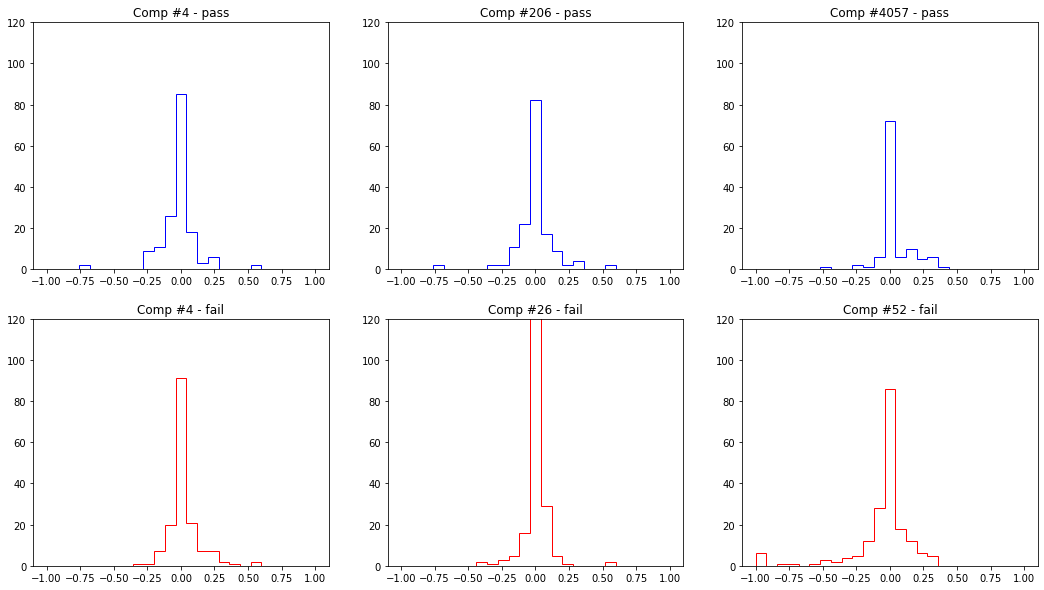

In [153]:
def create_subplots(ax, df, hist_range, bin_num, ylims, color, title_text):
    ax.hist(df, bins=bin_num, range=hist_range, color=color, histtype='step')
    ax.set_ylim(ylims)
    ax.set_title(title_text)
    return ax

plt.rcParams['figure.figsize'] = (18, 10)

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(234)
ax5 = plt.subplot(235)
ax6 = plt.subplot(236)

hist_range = [-1, 1]
ylims = [0,120]
bin_num = 25

ax1 = create_subplots(ax1, df_comp_a, hist_range, bin_num, ylims, 'blue', "Comp #{} - pass".format(df['Id'].iloc[comp_a]))
ax2 = create_subplots(ax2, df_comp_b, hist_range, bin_num, ylims, 'blue', "Comp #{} - pass".format(df['Id'].iloc[comp_b]))
ax3 = create_subplots(ax3, df_comp_c, hist_range, bin_num, ylims, 'blue', "Comp #{} - pass".format(df['Id'].iloc[comp_c]))
ax4 = create_subplots(ax4, df_comp_d, hist_range, bin_num, ylims, 'red', "Comp #{} - fail".format(df['Id'].iloc[comp_d]))
ax5 = create_subplots(ax5, df_comp_e, hist_range, bin_num, ylims, 'red', "Comp #{} - fail".format(df['Id'].iloc[comp_e]))
ax6 = create_subplots(ax6, df_comp_f, hist_range, bin_num, ylims, 'red', "Comp #{} - fail".format(df['Id'].iloc[comp_f]))

We have just plotted the values of all the sensor data for 3 passed components and 3 failed components into histograms. Each plot seems to be reasonably normal with potentially small degrees of skewness. One feature that may be an issue is the very large number of 0 values. This may be a genuine feature, but as this data appears to be normalised (values are alway between -1 and and 1) it may be due to the normalisation process or it may just be a default value of the sensors. This highlights the importance of understanding the source of the data and the sensor modality. However, in many cases we will be dealing with data in which the productions mechanisms will be unknown so so it's good practice to deal with data 'blindly'.

Visualisation of data can be a time consuming process, especially for larger datasets. Iterable scripts that auto-generate key statistics and plots can help to identify outliers which may have interesting or erroneous data points. In the next cell we will create the mean, median and variance values for the sensor data for each component, split by components which have passed or failed:

In [176]:
def generate_component_stats(df, median_list, mean_list, var_list):
    median_val = df.median()
    mean_val = df.mean()
    var_val = df.var()
    median_list.append(median_val)
    mean_list.append(mean_val)
    var_list.append(var_val)
    return median_list, mean_list, var_list

median_list_zero = []
mean_list_zero = []
var_list_zero = []
median_list_one = []
mean_list_one = []
var_list_one = []

for i in df_zero.index:
    median_list_zero, mean_list_zero, var_list_zero = generate_component_stats(df_zero.iloc[i,1:969].dropna(), median_list_zero, mean_list_zero, var_list_zero)

for i in df_one.index:
    median_list_one, mean_list_one, var_list_one = generate_component_stats(df_one.iloc[i,1:969].dropna(), median_list_one, mean_list_one, var_list_one)
       
    

To compare the difference between the lists of mean, median and variance for the passed and failed components, it will be better to plot on a single graph. Since the total number of values within the passed components (99432) compared to failed components (568), using a standard histogram would not be useful. Normalisation would allow a direct comparison.

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00357782, 0.02325581, 0.07334526,
        0.17710197, 0.31663685, 0.48300537, 0.60644007, 0.68694097,
        0.79248658, 0.83184258, 0.87298748, 0.8980322 , 0.9177102 ,
        0.93738819, 0.95348837, 0.97137746, 0.980322  , 0.98389982,
        0.98568873, 0.98747764, 0.98926655, 0.98926655, 0.99284436,
        0.99284436, 0.99463327, 0.99642218, 0.99642218, 0.99642218,
        0.99642218, 0.99642218, 0.99642218, 0.99642218, 0.99642218,
        0.99642218, 0.99642218, 0.99642218, 0.99642218, 0.99821109,
        1.        , 1.        , 1.        , 1.        ]),
 array([0.        , 0.00102041, 0.00204082, 0.00306122, 0.00408163,
        0.00510204, 0.00612245, 0.00714286, 0.00816327, 0.00918367,
        0.01020408, 0.01122449, 0.0122449 , 0.01326531, 0.01428571,
        0.01530612, 0.01632653, 0.01734694, 0.01836735, 0.01938776,
        0.02040816, 0.02142857, 0.02244898, 0.02346939, 0.

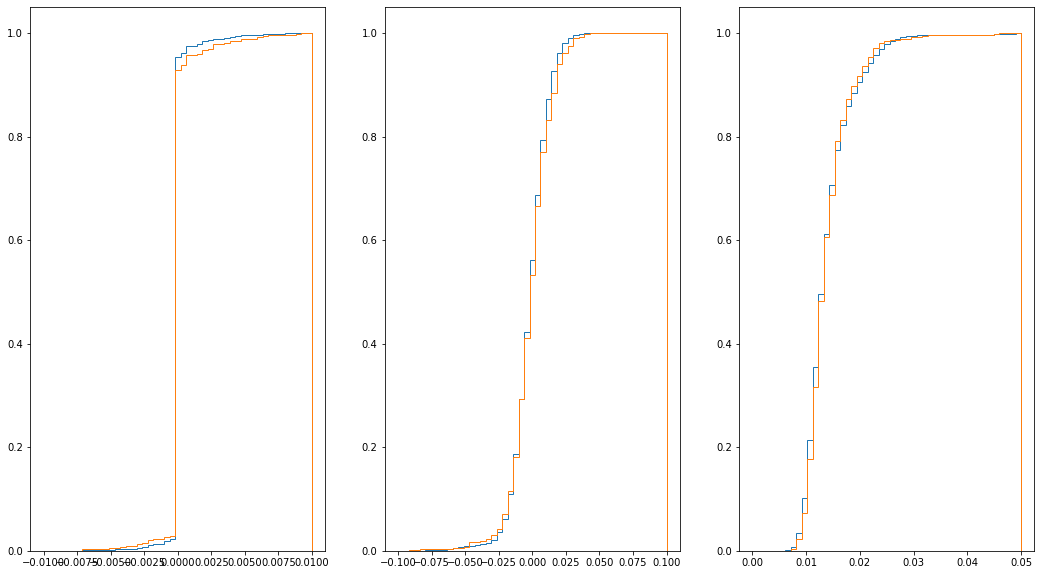

In [180]:
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

nbins = np.linspace(-0.01,0.01)
ax1.hist(median_list_zero, bins=nbins, cumulative=True, density=True, histtype='step')
ax1.hist(median_list_one, bins=nbins, cumulative=True, density=True, histtype='step')

nbins = np.linspace(-0.1,0.1)
ax2.hist(mean_list_zero, bins=nbins, cumulative=True, density=True, histtype='step')
ax2.hist(mean_list_one, bins=nbins, cumulative=True, density=True, histtype='step')

nbins = np.linspace(0,0.05)
ax3.hist(var_list_zero, bins=nbins, cumulative=True, density=True, histtype='step')
ax3.hist(var_list_one, bins=nbins, cumulative=True, density=True, histtype='step')

In [174]:
var_list_zero

[]